In [252]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm, t, f, ttest_1samp, ttest_rel, ttest_ind, zscore, f_oneway
import matplotlib.pyplot as plt

## 1. Central Limit Theorem

### Population Distribution

In [2]:
# FUNCTION 1
def logit(x, position = 0.5, spread = -20, setoff = 0, altitude = 1):
    return (1/(1+np.exp(spread * (x - position)))) * altitude + setoff

# FUNCTION 2
def gauss(x, position = 0.5, deviation = 0.1, height = 0, altitude = 1):
    return (np.exp(-np.power(x - position, 2.) / (2 * np.power(deviation, 2.))) + height) * altitude

# FUNCTION 3
def winner(x, position = None):
    xPoints = np.linspace(0, 1, 5)
    yPoints = [1, 0, 0.5, 0, 1]
    h = interp1d(xPoints, yPoints)
    return h(x)

# FUNCTION 4
def sine(x, position = 0.5):
    return (np.sin(10*x + position))*0.5+0.5

functions = [logit, gauss, winner, sine]

In [3]:
def generateDistribution(function, size=1):
    if size==1:
        x = np.random.rand()
        y = function(x)
        if np.random.rand() <= y:
            return x
        return generateDistribution(function)
    else:
        return np.array([generateDistribution(function) for _ in range(size)])

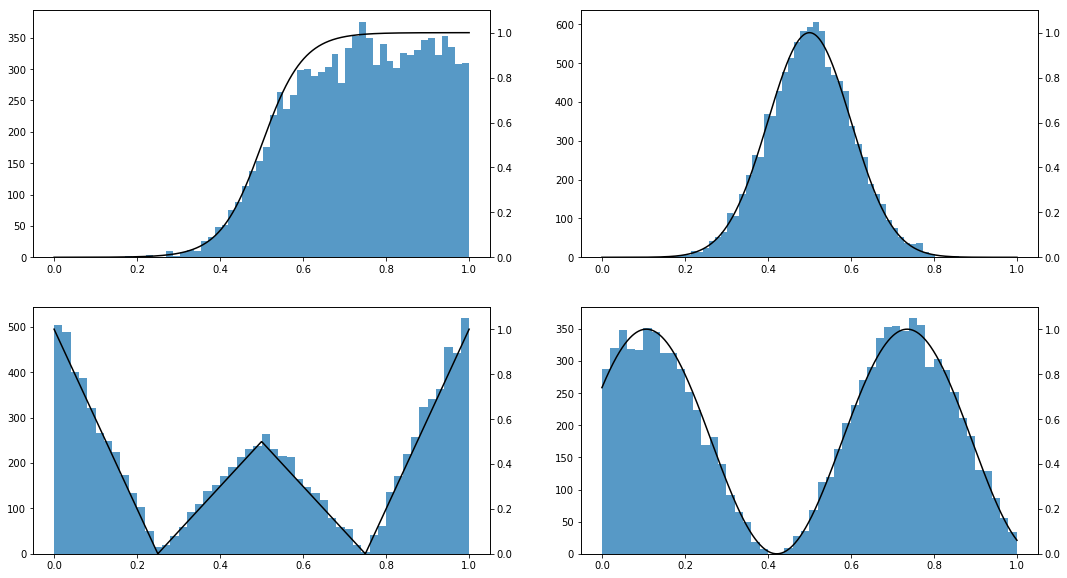

In [4]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
mean, sd = [], []
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    population = generateDistribution(f, 10000)
    ax.hist(population, bins=50, alpha=0.75)
    mean.append(population.mean())
    sd.append(np.std(population))
    ax2.plot(x, f(x), '-k'); ax2.set_ylim(0,1.1)
    #ax2.fill_between(x, 0, f(x), alpha=0.2)
plt.show()

### Sampling Distribution

In [5]:
SIZE = 5
SAMPLES = 10000
ZSCORE = 1.96

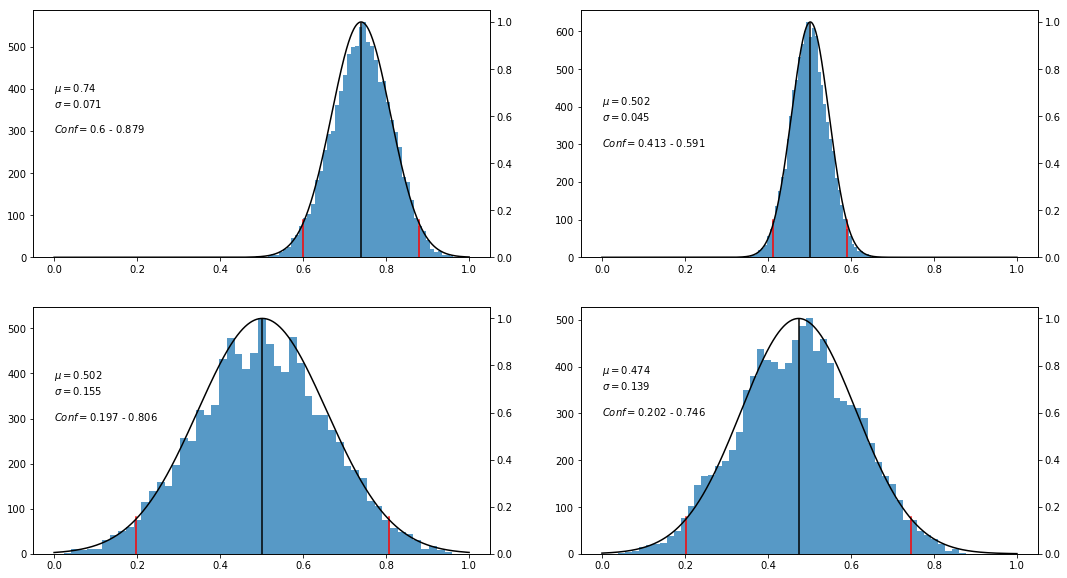

In [6]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    
    samplemeans = [generateDistribution(f, SIZE).mean() for _ in range(SAMPLES)]
    se = sd[i] / np.sqrt(SIZE)
    ci = (mean[i]-ZSCORE*se, mean[i]+ZSCORE*se) # = norm.interval(0.95, mean[i], se)
    
    ax.hist(samplemeans, bins=50, alpha=0.75)
    ax2.plot(x, gauss(x, mean[i], se), '-k'); ax2.set_ylim(0,)
    ax.text(0, 300, r'$\mu =$' + str(round(mean[i], 3)) + '\n' + r'$\sigma =$' + str(round(se, 3)) +
            '\n\n' + r'$Conf = $' + str(round(ci[0], 3)) + ' - ' + str(round(ci[1], 3)))
    
    ax.axvline(x=ci[0], color='r', ymax=0.15)
    ax.axvline(x=ci[1], color='r', ymax=0.15)
    ax.axvline(x=mean[i], color='k', ymax=0.95)
plt.show()

## Z & T-tests

### Percentage tables

<img src="img/z-table.jpg" style="width:530px;display:inline-block;"/>
<img src="img/t-table.jpg" style="width:370px;display:inline-block;vertical-align:top"/>

Z-scores

In [7]:
ZSCORE = 1.96
print 'Get Z-score from p-statistic: ', norm.ppf(.975)
print 'Get p-statistic from Z-score: ', norm.cdf(ZSCORE), norm.sf(ZSCORE)
print 
print 'Get CI from p-statistic: ', norm.interval(0.95)

Get Z-score from p-statistic:  1.95996398454
Get p-statistic from Z-score:  0.975002104852 0.0249978951482

Get CI from p-statistic:  (-1.959963984540054, 1.959963984540054)


P-scores

In [8]:
TSCORE = 1.65
DF = 999
print 'Get T-score from p-statistic: ', t.ppf(.95, DF)
print 'Get p-statistic from T-score: ', t.cdf(TSCORE, DF), t.sf(TSCORE, DF)
print
print 'Get CI/critical values from p-statistic: ', t.interval(0.95, DF)

Get T-score from p-statistic:  1.64638034543
Get p-statistic from T-score:  0.950371357874 0.0496286421255

Get CI/critical values from p-statistic:  (-1.9623414611334487, 1.9623414611334487)


### Helper functions

In [350]:
def plotGauss(mu0, se, cv, mean, title, apa=''):
    fig = plt.figure(figsize=(18, 5))
    x = np.linspace(mu0 - 4*se, mu0 + 4*se, num=1000)
    plt.plot(x, gauss(x, mu0, se), '-k'); plt.ylim(0,1.2)
    plt.fill_between(x, 0, gauss(x, mu0, se), alpha=0.2)
    
    # Sample mean
    plt.axvline(x=mean, color='r', ymax=gauss(mean, mu0, se)*0.83)
    plt.text(mean, gauss(mean, mu0, se)+.1, r'$\overline{x} =$' + str(round(mean, 3)))

    # Critical values
    ci = mu0 + cv * se
    plt.fill_between(x, 0, gauss(x, mu0, se), where=x<ci[0], color='r')
    plt.text(ci.item(0), 0.23, r'$cv =$' + str(round(ci.item(0), 3)))
    if ci.size == 2:
        plt.fill_between(x, 0, gauss(x, mu0, se), where=x>ci[1], color='r')
        plt.text(ci[1], 0.23, r'$cv =$' + str(round(ci[1], 3)))    
    
    # Standard errors
    for i in np.linspace(-3, 3, 7):
        plt.axvline(i*se+mu0, color='k', ymax=gauss(i*se+mu0, mu0, se)*0.83)
    
    plt.text(mu0, 1.1, r'$\mu_0 =$' + str(round(mu0, 3)))
    plt.text(mu0+se, 0.68, r'$\sigma =$' + str(round(se, 3)))
    plt.text(mu0+(-4*se), 0.9, apa)

    plt.title(title)
    plt.show()
    
def apa(df, T, p, kind):
    s = 't('+ str(df)+') = ' + str(round(T, 2))
    s += ', p = ' + str(round(p, 2)) + ', ' + kind
    return s

### One-sampled Z-test
Is there a significant difference between a sample and a given population distribution.

\begin{align} 
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}\\
z &= \frac{  {\overline{x} - \mu_0}}{{\sigma}}
\end{align}

In [351]:
# Descriptive statistics
sample = norm.rvs(loc=7, scale=2, size=10)
mean = np.mean(sample)
mu0, sigma = 8, 2
print mean
print sample

6.88666592767
[  7.98667589  10.03202545   9.36666742   8.14359021   3.72416799
   5.24461203   5.32609222   4.10256797   5.89178956   9.04847054]


In [352]:
# Inferential statistics
Z = (mean - mu0) / sigma
p = norm.cdf(Z)*2
cv = np.array(norm.interval(.95))
print Z, p, cv

-0.556667036166 0.577754942954 [-1.95996398  1.95996398]


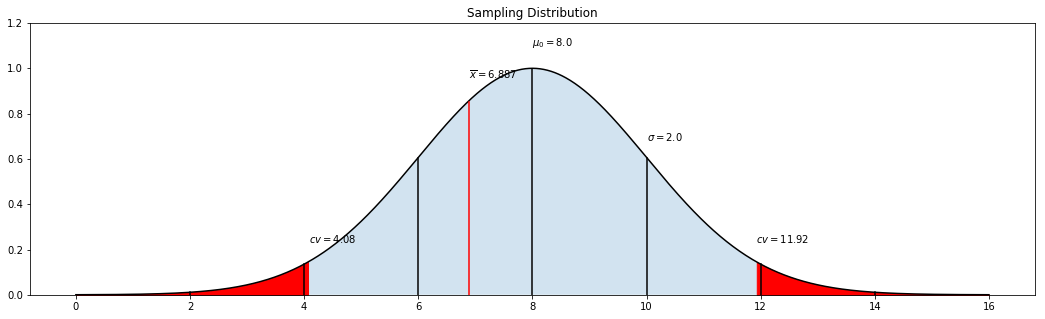

In [353]:
plotGauss(mu0, sigma, cv, mean, 'Sampling Distribution')

### One-sampled t-test
Is there a significant difference between a sample and a given population mean.

\begin{align} 
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}
&&s = \sqrt{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}} \\
s_e &= \frac{s}{\sqrt{n}}
&&t = \frac{  {\overline{x} - \mu_0}}{s_e}\\
d &= \frac{  {\overline{x} - \mu_0}}{s}
&&r^2 = \frac{t^2}{t^2+df}
\end{align}

In [354]:
# Descriptive statistics
sample = norm.rvs(loc=6, scale=2, size=15)
n, mean, sd = len(sample), np.mean(sample), np.std(sample)
print mean, sd
print sample

5.5924169434 2.03859999566
[  3.15214678   6.79622581   3.11421169   5.38067154   5.21848636
   7.49963194   4.14241438   5.5447771    4.05937952   8.82958092
   4.55387544  10.78483351   5.59083669   4.78956285   4.42961965]


In [355]:
# Inferential statistics
mu0 = 5.5
cv = np.array(t.interval(.95, n-1)) # t.ppf(.05, 24) one-tailed
se = sd / np.sqrt(n)
T = (mean - mu0) / se
p = t.cdf(T, n-1)*2
print T, p, cv
print ttest_1samp(sample, mu0)

0.175576024447 1.13685878692 [-2.14478669  2.14478669]
Ttest_1sampResult(statistic=0.16962255452387237, pvalue=0.86773358687272784)


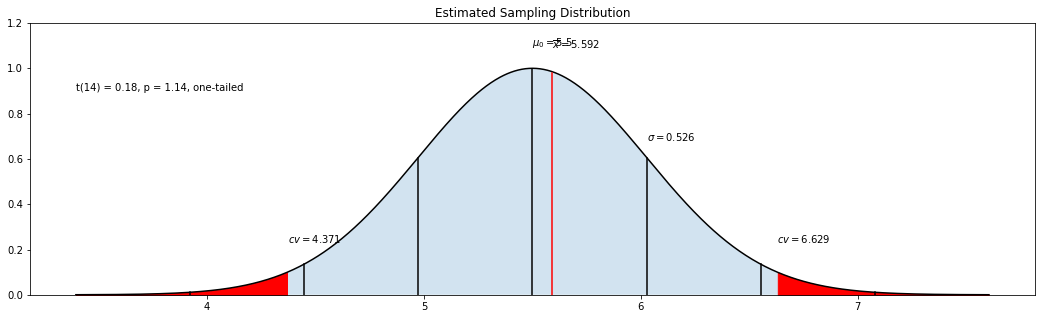

In [356]:
plotGauss(mu0, se, cv, mean, 'Estimated Sampling Distribution', apa(n-1, T, p, 'one-tailed'))

### Paired sampled t-test
Is there a significant difference between two dependent samples.

\begin{align}
x_i &= y_i - z_i\\
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}
&&s = \sqrt{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}} \\
s_e &= \frac{s}{\sqrt{n}}
&&t = \frac{  {\overline{x} - \mu_0}}{s_e}
\end{align}

In [357]:
# Descriptive statistics
sample1 = norm.rvs(loc=5.8, scale=2, size=15)
sample2 = norm.rvs(loc=6.1, scale=2, size=15)
sample = sample1 - sample2
n, mean, sd = len(sample), np.mean(sample), np.std(sample)
print mean, sd
print sample

-1.24843426712 2.10457569322
[-2.76459696 -3.38171924 -3.04204685 -2.46511558 -2.70754374 -3.47576498
 -3.22588672  0.83025445  1.93275635 -3.70771155  1.33651347 -0.04489026
 -0.52840683  0.21462383  2.30302059]


In [358]:
# Inferential statistics
mu0 = 0 # No difference
se = sd / np.sqrt(n-1)
T = (mean - mu0) / se
p = t.cdf(T, n-1)*2
cv = np.array(t.interval(.95, n -1))
print T, p, cv
print ttest_rel(sample1, sample2)

-2.21955110121 0.04347553127 [-2.14478669  2.14478669]
Ttest_relResult(statistic=-2.2195511012149294, pvalue=0.043475531270037296)


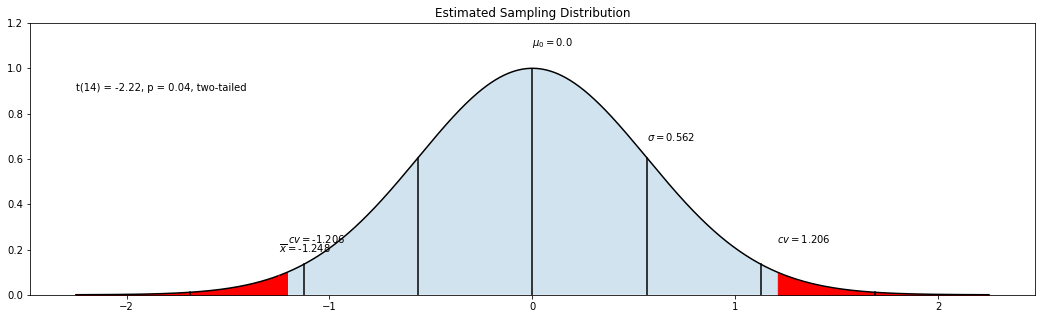

In [359]:
plotGauss(mu0, se, cv, mean, 'Estimated Sampling Distribution', apa(n-1, T, p, 'two-tailed'))

### Two sampled t-test
Is there a significant difference between independent samples.

\begin{align}
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}
&&\overline{y} = \frac{1}{m} \sum^n_{i=1}{y_i}\\
s_x &= \sqrt{{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}}} 
&& s_y = \sqrt{{\frac{ \sum^m_{i=1}{(y_i - \overline{y})^2} }{m-1}}} \\
s_p &= \sqrt{\frac{(n-1)s^2_x + (m-1)s^2_y}{n+m-2}}
&&s_e = s_p\sqrt{\frac{1}{n}+\frac{1}{m}}\\
t &= \frac{  {\overline{x} - \overline{y}}} {s_e}
\end{align}

In [360]:
# Descriptive statistics
sample1 = norm.rvs(loc=5.8, scale=2, size=15)
sample2 = norm.rvs(loc=6.1, scale=2, size=10)
n, mean1, sd1 = len(sample1), np.mean(sample1), np.std(sample1)
m, mean2, sd2 = len(sample2), np.mean(sample2), np.std(sample2)
print mean1, sd1, mean2, sd2
print sample1
print sample2

6.14453672423 1.78176926155 5.27889015046 1.67943670153
[ 8.98999692  5.74737744  6.59080672  1.74949796  6.42739357  5.19601271
  7.00666093  7.60466063  5.43766324  4.62901784  9.24524733  6.49802494
  5.374289    4.67901821  6.99238342]
[ 7.53671288  5.68239881  3.15588472  8.06824225  4.35317236  3.52848572
  6.81516102  3.3584729   5.71619454  4.57417632]


In [361]:
# Inferential statistics
mu0 = 0
sp = np.sqrt(((n-1) * np.power(sd1, 2) + (m-1) * np.power(sd2, 2)) / (n + m - 2))
se = sp * np.sqrt((1/float(n)+1/float(m)))
T = (mean1 - mean2) / se
p = t.cdf(T, n+m-2)*2
cv = np.array(t.interval(.95, n + m - 2))
print T, p, cv
print ttest_ind(sample1, sample2)

1.21690847579 1.76402090738 [-2.06865761  2.06865761]
Ttest_indResult(statistic=1.1678100933522138, pvalue=0.25484723165364681)


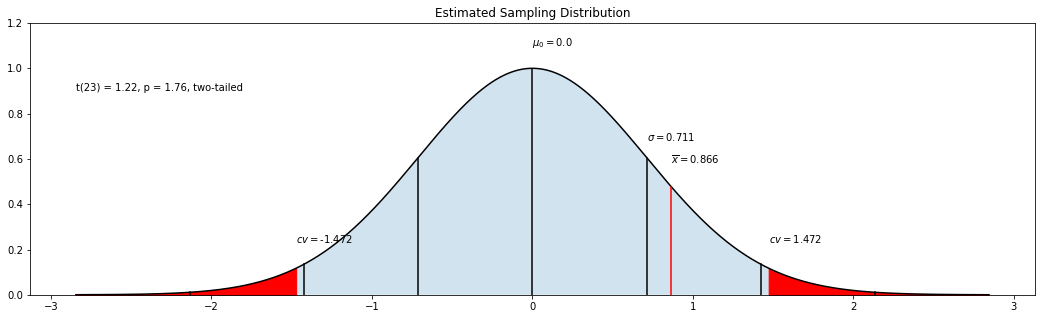

In [362]:
plotGauss(mu0, se, cv, mean1 - mean2, 'Estimated Sampling Distribution', apa(n+m-2, T, p, 'two-tailed'))

### Cohen's d and r squared

\begin{align}
s_p &= \sqrt{\frac{(n-1)s^2_x + (m-1)s^2_y}{n+m-2}}\\
d &= \frac{  {\overline{x} - \overline{y}}} {s_p}\\
r^2 &= \frac{t^2}{t^2+df}
\end{align}

## Analysis of variance - Anova

Descriptive statistics

In [397]:
samples = np.array([norm.rvs(m, s, n) for (m, s, n) in [(2, 2, 15), (10, 5, 15), (30, 2, 15)]])
statistics = [(np.mean(sample), np.std(sample), len(sample)) for sample in samples]
statistics

[(1.4251397976521867, 1.7399396698831415, 15),
 (10.103632687688528, 5.2835583209896413, 15),
 (30.371174693150223, 2.2308213527925367, 15)]

* As the between group variability increases, the F-statistic increases as well.
* As the within group variability increases, the F-statistic decreases.

|Sample 1   |Sample 2   |Sample k   | Grand mean  |
|--:|--:|--:|--:|
| $x_1$  | $x_1$  |$x_1$  |   |   
| $x_2$  | $x_2$  |$x_2$  |   |   
| $x_3$  | $x_3$  |$x_3$  |   |   
| $x_{n}$  | $x_{n}$  |$x_{n}$  |   |   
|  $\overline{x}_k$ | $\overline{x}_k$  | $\overline{x}_k$  | $\overline{x}_G$  |

\begin{align}
F &= \frac{between\ group\ variability}{within\ group\ variablilty} 
= \frac{\sum^k_{k=1}{n_k(\overline{x}_k-\overline{x}_G)^2}\ /\ (k-1)}{\sum^k_{k=1}{(\overline{x}_i-\overline{x}_k)^2}\ /\ (N-k)}
= \frac{SS_{between}\ /\ df_{between}}{SS_{within}\ /\ df_{within}}
\end{align}

Inferential statistics

In [399]:
grandMean = samples.flatten().mean()
sampleMeans = np.array([x[0] for x in statistics])
sampleSizes = np.array([x[2] for x in statistics])

In [400]:
ssb = np.sum(np.power(sampleMeans - grandMean, 2) * sampleSizes)
ssw = np.sum([np.power(np.array(xi)-xk, 2) for xi, xk in zip(samples, sampleMeans)])
dfb = len(sampleSizes) - 1
dfw = len(samples.flatten()) - len(sampleSizes)

In [401]:
F = (ssb / dfb) / (ssw / dfw)
print F, f.sf(F, dfb, dfw)
print f_oneway(samples[0], samples[1], samples[2])

258.010909655 2.56188896923e-24
F_onewayResult(statistic=258.01090965536366, pvalue=2.5618889692323504e-24)


Critical values, link to <a href="http://www.socr.ucla.edu/applets.dir/f_table.html">F-table</a>.

In [402]:
Fcrit = f.ppf(0.95, dfb, dfw)
print Fcrit, 'Null hypothesis rejected?', F > Fcrit

3.21994229318 Null hypothesis rejected? True


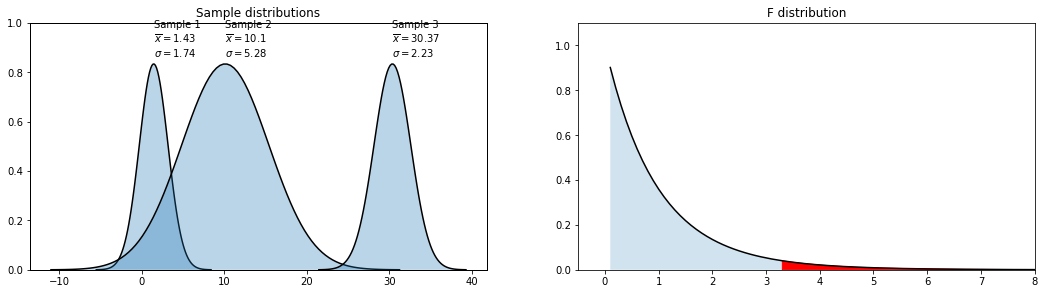

In [420]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
for i, (m, s, n) in enumerate(statistics):
    axx = ax1.twinx()
    x = np.linspace(m-4*s, m+4*s, num=100)
    axx.plot(x, gauss(x, m, s), '-k')
    axx.fill_between(x, 0, gauss(x, m, s), alpha=0.3)
    axx.text(m, 1.04, 'Sample '+ str(i+1)+'\n' +
             r'$\overline{x} =$' + str(round(m, 2)) + '\n' + 
             r'$\sigma =$' + str(round(s, 2)))
    axx.set_ylim(0,1.2); axx.get_yaxis().set_visible(False)
ax1.set_title('Sample distributions')

x = np.linspace(0, 7.5, num=1000)
ax2.plot(x, f.pdf(x, dfb, dfw), '-k')
ax2.fill_between(x, 0, f.pdf(x, dfb, dfw), alpha=0.2)
ax2.fill_between(x, 0, f.pdf(x, dfb, dfw), where=x>Fcrit, color='r')
ax2.axvline(x=F, color='r', ymax=f.pdf(F, dfb, dfw)*0.9)
ax2.set_ylim(0,1.1); ax2.set_xlim(-.5,8)
ax2.set_title('F distribution')


plt.show()